# Maximum Likelihood Estimation

In [41]:
import pandas as pd
import numpy as np  
from scipy.optimize import minimize  

from sklearn.model_selection import StratifiedGroupKFold
import scipy

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)

import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet("final_data.parquet")
df

,constructorId,constructor_name,constructorStandingsId,raceId_x,constructor_pos,constructor_wins,constructorResultsId,constructor_points,round,circuitId,...,Points_Per_Entry,Years_Active,Champion,driverRef,code,driverStandingsId,raceId_y,points,position,driver_wins
0,1,McLaren,26936.0,989.0,4.0,0.0,15643.0,12.0,1,1,...,5.78273,19,True,alonso,ALO,4,18,5.0,4,0
1,1,McLaren,26936.0,989.0,4.0,0.0,15643.0,12.0,1,1,...,5.78273,19,True,alonso,ALO,12,19,6.0,7,0
2,1,McLaren,26936.0,989.0,4.0,0.0,15643.0,12.0,1,1,...,5.78273,19,True,alonso,ALO,30,20,6.0,9,0
3,1,McLaren,26936.0,989.0,4.0,0.0,15643.0,12.0,1,1,...,5.78273,19,True,alonso,ALO,51,21,6.0,10,0
4,1,McLaren,26936.0,989.0,4.0,0.0,15643.0,12.0,1,1,...,5.78273,19,True,alonso,ALO,72,22,9.0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355645,214,Alpine F1 Team,28708.0,1120.0,6.0,0.0,16886.0,0.0,22,24,...,3.06422,6,False,gasly,GAS,73126,1140,9.0,16,0
355646,214,Alpine F1 Team,28708.0,1120.0,6.0,0.0,16886.0,0.0,22,24,...,3.06422,6,False,gasly,GAS,73172,1141,26.0,12,0
355647,214,Alpine F1 Team,28708.0,1120.0,6.0,0.0,16886.0,0.0,22,24,...,3.06422,6,False,gasly,GAS,73218,1142,26.0,12,0
355648,214,Alpine F1 Team,28708.0,1120.0,6.0,0.0,16886.0,0.0,22,24,...,3.06422,6,False,gasly,GAS,73241,1143,36.0,11,0


In [3]:
missing_columns = df.columns[df.isna().any()]
print("Columns with missing or NaN values:")
print(missing_columns)

Columns with missing or NaN values:
Index(['AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed'],
      dtype='object')


## Predicting the probability that drivers will place in the top 3

Preparing the data: Perform binary classification for whether a driver/constructor duo has placed in the top 3

In [4]:
df['results_pos'] = pd.to_numeric(df['results_pos'], errors='coerce')
df = df.fillna(22)
df['results_pos'] = df['results_pos'].astype(int)
df['top_3'] = (df['results_pos'] < 4)
df['top_3'] = df['positionOrder'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

Preparing the data: Drop rows with missing positionOrder or needed features

In [5]:
df = df.dropna(subset=['positionOrder', 'constructorId', 'driverId'])

Making the predictions with MLE

In [6]:
# useful features for making top 3 predictions
feature_cols = [ # determined essential feature for making constructor x driver predictions
    'grid', 'constructor_points', 'constructor_wins', 'Pole_Rate', 'Win_Rate', 
    'Points_Per_Entry', 'Years_Active', 'Race_Wins', 'Fastest_Laps',
    'Podium_Rate', 'Points', 'Start_Rate', 'driver_wins','FastLap_Rate'
]
# check existing columns else drop
df = df.dropna(subset=feature_cols)

X = df[feature_cols]
y = df['top_3']
groups = df['raceId_x']  # group by race

# group-aware train-test split
split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(split.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


In [7]:
# Train Logistic Regression (MLE under the hood)
model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000
)
model.fit(X_train, y_train)


c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [8]:
# Evaluation
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

In [9]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9428219664433374
Precision: 0.8383680555555556
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     54164
           1       0.84      0.92      0.88     15688

    accuracy                           0.94     69852
   macro avg       0.91      0.94      0.92     69852
weighted avg       0.95      0.94      0.94     69852



## MLE Predictions

In [10]:
#Putting predictions in the dataframe
constructor_winners = df.loc[X_test.index].copy()
constructor_winners['predicted_winner']= y_probs
constructor_winners['predicted_winner_probability']= y_pred

In [11]:
#get the names of all the races
unique_race_names = df['race_name'].unique()
print(unique_race_names)

['Australian Grand Prix' 'Bahrain Grand Prix' 'Chinese Grand Prix'
 'Azerbaijan Grand Prix' 'Spanish Grand Prix' 'Monaco Grand Prix'
 'Canadian Grand Prix' 'French Grand Prix' 'Austrian Grand Prix'
 'British Grand Prix' 'German Grand Prix' 'Hungarian Grand Prix'
 'Belgian Grand Prix' 'Italian Grand Prix' 'Singapore Grand Prix'
 'Russian Grand Prix' 'Japanese Grand Prix' 'United States Grand Prix'
 'Mexican Grand Prix' 'Brazilian Grand Prix' 'Abu Dhabi Grand Prix'
 'Styrian Grand Prix' '70th Anniversary Grand Prix' 'Tuscan Grand Prix'
 'Eifel Grand Prix' 'Portuguese Grand Prix' 'Emilia Romagna Grand Prix'
 'Turkish Grand Prix' 'Sakhir Grand Prix' 'Qatar Grand Prix'
 'Dutch Grand Prix' 'Mexico City Grand Prix' 'São Paulo Grand Prix'
 'Saudi Arabian Grand Prix' 'Miami Grand Prix' 'Las Vegas Grand Prix']


In [12]:
def get_prediction(race_name):
        filtered= constructor_winners[constructor_winners['race_name'] == race_name]
        
        if len(filtered) == 0:
            return f"No data for race: {race_name}"

        filtered= filtered.drop_duplicates(subset=['driverId'])
        
        return filtered.sort_values('predicted_winner_probability', ascending=False)

In [13]:
country= "Bahrain"
race= f"{country} Grand Prix"
race_pred= get_prediction(race)

# print(f"\nPredictions for {race}:")
# print(race_pred[['forename', 'surname', 'predicted_winner_probability']].head(10))

#looked online for how to make it look nicer
print(f"\n--- Predictions for {race} ---")
print(f"{'Position':<8} {'Driver':<25} {'Win Probability':<15}")
print("-" * 50)

for i, (_, row) in enumerate(race_pred.head(3).iterrows(), 1):
    driver_name = f"{row['forename']} {row['surname']}"
    probability = f"{row['predicted_winner_probability']*100:.2f}%"
    print(f"{i:<8} {driver_name:<25} {probability:<15}")

#no lie i stole this code just so it looks nice. Please dont judge me -Saeed
# don't worry its been a long semester and same. have my model and just following your process - Zidane


--- Predictions for Bahrain Grand Prix ---
Position Driver                    Win Probability
--------------------------------------------------
1        Max Verstappen            100.00%        
2        Alexander Albon           100.00%        
3        Lewis Hamilton            100.00%        


In [14]:
# useful features for making top 3 predictions
feature_cols = [ # determined essential feature for making constructor x driver predictions
    'grid', 'laps', 'results_points', 'fastestLapSpeed',  #race and performance info
    'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed',  #weather/track conditions
    'Race_Entries', 'Race_Starts', 'Pole_Positions', 'Race_Wins', 'Podiums', #rest is for driver performance
    'Fastest_Laps', 'Points', 'Pole_Rate', 'Start_Rate', 'Win_Rate', 'Podium_Rate',
    'FastLap_Rate', 'Points_Per_Entry', 'Years_Active'
]

# check existing columns else drop
df = df.dropna(subset=feature_cols)

X = df[feature_cols]
y = df['top_3']
groups = df['raceId_x']  # group by race

# group-aware train-test split
split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(split.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
# Convert any non-numeric columns in feature_cols to numeric, coerce errors to NaN, then drop rows with NaN
for col in feature_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.dropna()
y = y.loc[X.index]
groups = groups.loc[X.index]

# Redefine train/test split after cleaning
train_idx, test_idx = next(split.split(X, y, groups))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]



C:\Users\zidti\AppData\Local\Temp\ipykernel_9896\2324257232.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce')


In [15]:
# Train Logistic Regression (MLE under the hood)
model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000
)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [16]:
# Evaluation
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

In [17]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9947670145524034
Precision: 0.9777444361090273
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     52390
           1       0.98      1.00      0.99     15640

    accuracy                           0.99     68030
   macro avg       0.99      1.00      0.99     68030
weighted avg       0.99      0.99      0.99     68030



In [18]:
model = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced')
model.fit(X_train, y_train)

c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [19]:
# Evaluation
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

In [20]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9790239600176392
Precision: 0.9163883517900041
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     52390
           1       0.92      1.00      0.96     15640

    accuracy                           0.98     68030
   macro avg       0.96      0.99      0.97     68030
weighted avg       0.98      0.98      0.98     68030



### Finding the best parameters and regularization methods

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000),
                           param_grid,
                           cv=5,
                           scoring='f1')  # or 'roc_auc' if class imbalance
grid_search.fit(X_train, y_train)

c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10]}, scoring='f1')

In [22]:
model = LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Evaluation
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9947670145524034
Precision: 0.9777444361090273
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     52390
           1       0.98      1.00      0.99     15640

    accuracy                           0.99     68030
   macro avg       0.99      1.00      0.99     68030
weighted avg       0.99      0.99      0.99     68030



c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# Drop rows with missing target
df = df.dropna(subset=['positionOrder'])

# Define top-3 label
df['positionOrder'] = pd.to_numeric(df['positionOrder'], errors='coerce')
df['top_3'] = df['positionOrder'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# Define features
feature_cols = [
    'grid', 'laps', 'results_points',  # removed post race data which may have making the data assess on metrics would not have been available during an actual race
    'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed',
    'Race_Entries', 'Race_Starts', 'Pole_Positions', 'Race_Wins', 'Podiums',
    'Fastest_Laps', 'Points', 'Pole_Rate', 'Start_Rate', 'Win_Rate', 'Podium_Rate',
    'FastLap_Rate', 'Points_Per_Entry', 'Years_Active'
]

# Drop rows with missing feature values
df = df.dropna(subset=feature_cols)

# Extract features and target
X = df[feature_cols].apply(pd.to_numeric, errors='coerce')
y = df['top_3'].astype(int)
groups = df['raceId_x']  # Group by race

# Final NaN handling
valid_idx = X.dropna().index
X, y, groups = X.loc[valid_idx], y.loc[valid_idx], groups.loc[valid_idx]

# Train-test split using GroupShuffleSplit (group by race)
split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(split.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Logistic Regression (MLE-style) with balanced class weights
model = LogisticRegression(penalty='l2', C=0.1, max_iter=1000, class_weight='balanced', solver='lbfgs')
model.fit(X_train, y_train)

# Prediction
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_probs))
print(classification_report(y_test, y_pred))

Accuracy: 0.9858414934432801
Precision: 0.9558394839670037
ROC AUC: 0.9985210741728682
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     54164
           1       0.96      0.98      0.97     15688

    accuracy                           0.99     69852
   macro avg       0.98      0.98      0.98     69852
weighted avg       0.99      0.99      0.99     69852



c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
print(set(groups.iloc[train_idx]) & set(groups.iloc[test_idx]))

set()


In [27]:
def get_top3_predictions(race_name):
    race_df = constructor_winners[constructor_winners['race_name'] == race_name]
    if race_df.empty:
        return f"No data for {race_name}"
    
    top3 = race_df.drop_duplicates(subset=['driverId']) \
                  .sort_values('predicted_proba', ascending=False).head(3)
    
    print(f"\n--- Top-3 Prediction for {race_name} ---")
    print(f"{'Position':<8} {'Driver':<25} {'Win Probability':<15}")
    print("-" * 50)
    
    for i, (_, row) in enumerate(top3.iterrows(), 1):
        driver_name = f"{row['forename']} {row['surname']}"
        probability = f"{row['predicted_proba']*100:.2f}%"
        print(f"{i:<8} {driver_name:<25} {probability:<15}")
    
    return top3

In [28]:
# puting predictions to dataframe
constructor_winners = df.loc[X_test.index].copy()
constructor_winners['predicted_proba'] = y_probs

In [29]:
# Top-3 prediction for Bahrain Grand Prix
get_top3_predictions("Bahrain Grand Prix")


--- Top-3 Prediction for Bahrain Grand Prix ---
Position Driver                    Win Probability
--------------------------------------------------
1        Max Verstappen            100.00%        
2        Lewis Hamilton            100.00%        
3        Alexander Albon           100.00%        


,constructorId,constructor_name,constructorStandingsId,raceId_x,constructor_pos,constructor_wins,constructorResultsId,constructor_points,round,circuitId,...,Champion,driverRef,code,driverStandingsId,raceId_y,points,position,driver_wins,top_3,predicted_proba
116726,9,Red Bull,27641.0,1045.0,2.0,1.0,16201.0,34.0,15,3,...,True,max_verstappen,VER,68160,969,10.0,5,0,1,1.000000
227930,131,Mercedes,27633.0,1045.0,1.0,13.0,16200.0,29.0,15,3,...,True,hamilton,HAM,1,18,10.0,1,1,1,1.000000
116935,9,Red Bull,27641.0,1045.0,2.0,1.0,16201.0,34.0,15,3,...,False,albon,ALB,69762,1010,0.0,14,0,1,0.999999


These result gave the most favourable and least suspicious results when determining performance, however we need to discuss the out of predictions. Additionally we stll want to get the best hyperparameters for these results and as such use the one from the grid search suggestion.

In [30]:
# useful features for making top 3 predictions
feature_cols = [ # determined essential feature for making constructor x driver predictions
    'grid', 'constructor_points', 'constructor_wins', 'Pole_Rate', 'Win_Rate', 
    'Points_Per_Entry', 'Years_Active', 'Race_Wins', 'Fastest_Laps',
    'Podium_Rate', 'Points', 'Start_Rate', 'driver_wins','FastLap_Rate'
]
# check existing columns else drop
df = df.dropna(subset=feature_cols)

X = df[feature_cols]
y = df['top_3']
groups = df['raceId_x']  # group by race

# group-aware train-test split
split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(split.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Logistic Regression (MLE-style) with balanced class weights
model = LogisticRegression(penalty='l2', C=0.1, max_iter=1000, class_weight='balanced', solver='lbfgs')
model.fit(X_train, y_train)

# Prediction
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_probs))
print(classification_report(y_test, y_pred))

Accuracy: 0.9181555288323885
Precision: 0.7395838339180163
ROC AUC: 0.9843775673016932
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     54164
           1       0.74      0.98      0.84     15688

    accuracy                           0.92     69852
   macro avg       0.87      0.94      0.89     69852
weighted avg       0.94      0.92      0.92     69852



c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


This is used to check if there is Duplicate or Overlapping Data in Train/Test

In [31]:
print(set(groups.iloc[train_idx]) & set(groups.iloc[test_idx]))

set()


Preparing to make predictions

In [32]:
# puting predictions to dataframe
constructor_winners = df.loc[X_test.index].copy()
constructor_winners['predicted_proba'] = y_probs

In [33]:
# Top-3 prediction for Bahrain Grand Prix
get_top3_predictions("Bahrain Grand Prix")


--- Top-3 Prediction for Bahrain Grand Prix ---
Position Driver                    Win Probability
--------------------------------------------------
1        Max Verstappen            98.83%         
2        Lewis Hamilton            89.69%         
3        Alexander Albon           86.84%         


,constructorId,constructor_name,constructorStandingsId,raceId_x,constructor_pos,constructor_wins,constructorResultsId,constructor_points,round,circuitId,...,Champion,driverRef,code,driverStandingsId,raceId_y,points,position,driver_wins,top_3,predicted_proba
116726,9,Red Bull,27641.0,1045.0,2.0,1.0,16201.0,34.0,15,3,...,True,max_verstappen,VER,68160,969,10.0,5,0,1,0.988281
227930,131,Mercedes,27633.0,1045.0,1.0,13.0,16200.0,29.0,15,3,...,True,hamilton,HAM,1,18,10.0,1,1,1,0.896850
116935,9,Red Bull,27641.0,1045.0,2.0,1.0,16201.0,34.0,15,3,...,False,albon,ALB,69762,1010,0.0,14,0,1,0.868367


Another method for making predictions. I this we replace GroupShuffleSplit with StratifiedGroupKFold

In [46]:
# Load your data
df = pd.read_parquet("final_data.parquet")

# Label target and features
df['top_3'] = df['positionOrder'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# Only use the selected features
feature_cols = [
    'grid', 'constructor_points', 'constructor_wins', 'Pole_Rate', 'Win_Rate', 
    'Points_Per_Entry', 'Years_Active', 'Race_Wins', 'Fastest_Laps',
    'Podium_Rate', 'Points', 'Start_Rate', 'driver_wins', 'FastLap_Rate'
]

df = df.dropna(subset=feature_cols + ['raceId_x', 'positionOrder'])
X = df[feature_cols]
y = df['top_3']
groups = df['raceId_x']

# Convert features to numeric
for col in feature_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.dropna()
y = y.loc[X.index]
groups = groups.loc[X.index]

# Model
model = LogisticRegression(penalty='l2', C=0.1, class_weight='balanced', solver='lbfgs', max_iter=1000)

# Stratified Group K-Fold
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
all_y_true = []
all_y_probs = []

for train_idx, test_idx in cv.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_test)[:, 1]

    all_y_true.extend(y_test)
    all_y_probs.extend(y_probs)

# Metrics
all_y_true = np.array(all_y_true)
all_y_pred = (np.array(all_y_probs) > 0.5).astype(int)

print("Accuracy:", accuracy_score(all_y_true, all_y_pred))
print("Precision:", precision_score(all_y_true, all_y_pred))
print("Recall:", recall_score(all_y_true, all_y_pred))
print("F1 Score:", f1_score(all_y_true, all_y_pred))
print("ROC AUC:", roc_auc_score(all_y_true, all_y_probs))
print("Log Loss:", log_loss(all_y_true, all_y_probs))
print(classification_report(all_y_true, all_y_pred))

C:\Users\zidti\AppData\Local\Temp\ipykernel_9896\601814035.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce')
c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: 

Accuracy: 0.8946661043160411
Precision: 0.7111768295545229
Recall: 0.9187619012965591
F1 Score: 0.8017505979975021
ROC AUC: 0.961728158447684
Log Loss: 0.2521305222787634
              precision    recall  f1-score   support

           0       0.97      0.89      0.93    273201
           1       0.71      0.92      0.80     82449

    accuracy                           0.89    355650
   macro avg       0.84      0.90      0.87    355650
weighted avg       0.91      0.89      0.90    355650



Visualization

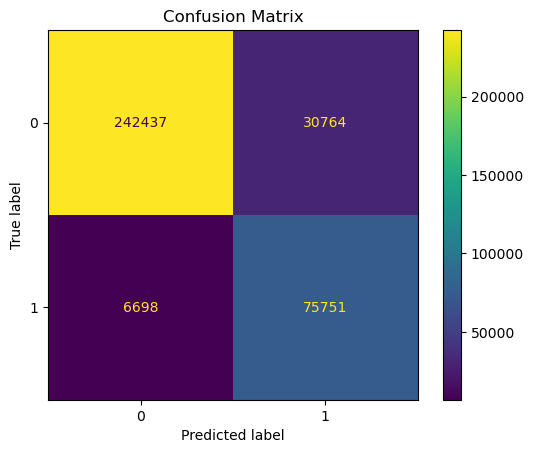

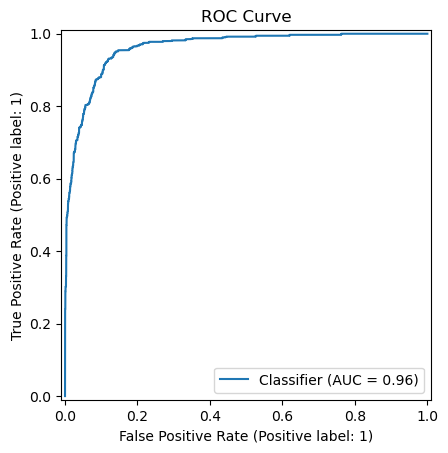

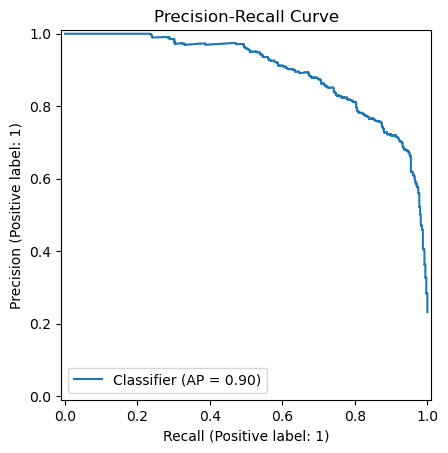

In [47]:
# Confusion Matrix
cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(all_y_true, all_y_probs)
plt.title("ROC Curve")
plt.show()

# Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(all_y_true, all_y_probs)
plt.title("Precision-Recall Curve")
plt.show()

Redoing the get top 3 predictions

In [48]:
def get_top_3_predictions(race_name: str, full_df: pd.DataFrame, model, feature_cols):
    race_df = full_df[full_df['race_name'] == race_name].copy()
    race_df = race_df.dropna(subset=feature_cols)
    race_features = race_df[feature_cols].apply(pd.to_numeric, errors='coerce').dropna()
    
    race_probs = model.predict_proba(race_features)[:, 1]
    race_df = race_df.loc[race_features.index]
    race_df['win_probability'] = race_probs
    
    top3 = race_df.sort_values('win_probability', ascending=False).head(3)
    print(f"\n--- Predicted Top 3 for {race_name} ---")
    print(f"{'Position':<8} {'Driver':<25} {'Win Probability':<15}")
    print("-" * 50)
    for i, (_, row) in enumerate(top3.iterrows(), 1):
        driver_name = f"{row['forename']} {row['surname']}"
        probability = f"{row['win_probability']*100:.2f}%"
        print(f"{i:<8} {driver_name:<25} {probability:<15}")


In [49]:
get_top_3_predictions("Bahrain Grand Prix", df, model, feature_cols)


--- Predicted Top 3 for Bahrain Grand Prix ---
Position Driver                    Win Probability
--------------------------------------------------
1        Max Verstappen            99.80%         
2        Max Verstappen            99.80%         
3        Max Verstappen            99.79%         
